In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


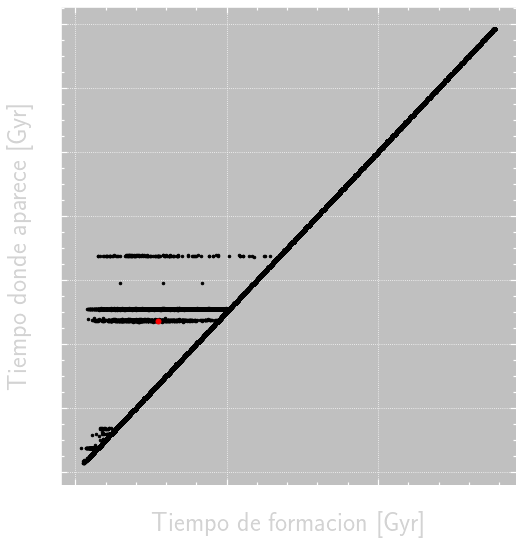

In [44]:
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True


cm0 = np.loadtxt('/home/ornela/python/salida/test_data.dat')
tform = cm0[:,1]
time  = cm0[:,2]
time2 = cm0[:,3]

fig=plt.figure(1, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax=fig.add_subplot(111)
#     ax.plot(xn,yn,'.', markersize=0.1, color='k')
ax.plot(tform,time,'.', markersize=5, color='k')
ax.plot(tform[3],time2[3],'.', markersize=10, color='r')
#     ax.set_xlim(-5,5)
#     ax.set_ylim(-5,5)
ax.spines['bottom'].set_color('w')
ax.spines['top'].set_color('w')
ax.spines['left'].set_color('w')
ax.spines['right'].set_color('w')
ax.minorticks_on()
ax.tick_params( labelsize=22, colors='lightgray')
ax.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on',colors='w')
ax.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on',colors='w')  
ax.set_facecolor('silver')
ax.grid(color='w',linestyle=':',which='major')
#ax.grid(color='lightgray',linestyle=':',which='minor')
ax.set_xlabel('Tiempo de formacion [Gyr]', fontsize=26, color='lightgray')
ax.set_ylabel('Tiempo donde aparece [Gyr]',fontsize=26, color='lightgray')
plt.show()

In [14]:
cm0    = np.loadtxt('/home/ornela/python/salida/part_barra.dat')
ID    = cm0[:,0]
tform = cm0[:,1]
rn_z0 = cm0[:,2]

print len(ID)

181874


## Particulas de la barra en z=0

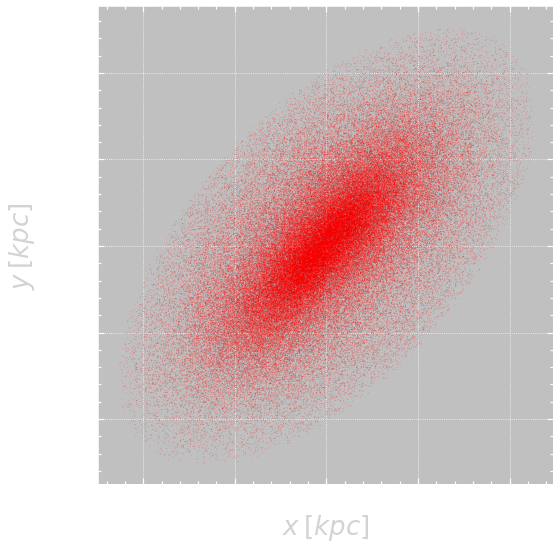

In [4]:
import h5py
import rotation as rot
import barstrength as strng
import time_conversion as tiempo


#Parámetros cosmológicos
#--------------------------------------------------------------------------
h=0.732
G = 4.299e-6
a0=1.
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
#---------------------------------------------------------------------------
aa = np.loadtxt('/home/ornela/python/ornella/redshift_outputs.txt')
aexp = aa[:,2]

cm = np.loadtxt('/home/ornela/python/barras/lbar_time2.dat')
lbar = cm[:,2]

snapshot=range(496,495,-1) #SNAPSHOTS
i=0
for isnap in snapshot:
    
    snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')

    cm    = snap['subhalo_000/Center'].value
    r200  = snap['subhalo_000/R200'].value
    IDs   = snap['subhalo_000/Str/Ids'].value
    formt = snap['subhalo_000/Str/FormationTime'].value
    pstr  = snap['subhalo_000/Str/Coordinates'].value
    mstr  = snap['subhalo_000/Str/Masses'].value
    vel   = snap['subhalo_000/Str/Velocities'].value
  
    z     = a0/aexp[isnap] - 1.
    Ht    = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
    time  = tiempo.conv(z, h, omega_lambda, omega_matter)
    
    aux   = a0/formt - 1.
    tform = tiempo.conv(aux, h, omega_lambda, omega_matter)

#paso las coordenadas al centro de la galaxia y paso a coordenadas físicas
    xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
    ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
    zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
    r    = np.sqrt(xstr**2+ystr**2+zstr**2)
    
#paso las velocidades a unidades físicas
    v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
    v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
    v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.


    mstr = mstr/h     #masa a unidades físicas

    r200 = r200*aexp[isnap]/h #radio virial a unidades fisicas

    rgal = 0.15*r200          #defino el radio de la galaxia

    limit = np.where(r<rgal)         #hago un límite de los r dentro de rgal
    r_sort = np.sort(r[limit])       #acomodo los r de menor a mayor
    r_indice = np.argsort(r[limit])  #saco los argumentos de r acomodados de menor a mayor

    Mc_str = cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
    Mgal = Mc_str[-1]  #masa total de la galaxia

#Calculo de los radios a 50% y 90% la masa de la galaxia
#-----------------------------------------------------------------------
    razon = Mc_str/Mgal 
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa][-1]   #radio a 90% la masa
    r50 = r_sort[cincuenta][-1] #radio a 50% la masa
    
#-----------------------------------------------------------------------
#componentes de la velocidad del centro de masa
    veloc, = np.where(r < r50)
    
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

#velocidades de las estrellas respecto del centro de masa de la galaxia
    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm


#calculo el raux
#     raux = 2*r50
#------------------------------------------------------------------------------------
    dd = range(496,300,-1)
    dd.remove(428)
    if isnap in dd:
        raux = 2*r50
    elif (isnap == 428) or ((isnap < 301) & (isnap > 283)):
        raux = r50
    elif (isnap > 271) & (isnap < 284):
        raux = 0.75
    elif isnap < 272:
        raux = 0.5
#-----------------------------------------------------------------------------------

#hago la rotación de las coordenadas respecto del momento angular    
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,raux)

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz
    
    rn  = np.sqrt(xn**2 + yn**2 + zn**2)
    
    #--------------------------------------------------------------------------------------    

    corte, = np.where(r<raux)
    
    A2max, rmax, phi = strng.a2max(mstr[corte], xn[corte], yn[corte], 20)
    
    phi = phi/2.
    
#Definimos el tamaño de nuestro elipsoide
    aa=lbar[i]
    bb=0.5*lbar[i]
    cc=0.5*lbar[i]
    
#Hacemos la rotación de las coordenadas
    xx = xn*cos(phi)+yn*sin(phi)
    yy = xn*sin(phi)-yn*cos(phi)
    zz = zn
    RR = np.sqrt((xx/aa)**2+(yy/bb)**2+(zz/cc)**2) # formula del elipsoide
    
    mask, = np.where(RR<1) #seleccionamos las particulas dentro del elipsoide
    
    ID    = IDs[mask]
    tform = tform[mask]
    rn_z0 = rn[mask]
    
#Guargamos los parámetros en distintos archivos
#----------------------------------------------------------------------------------
#     datos = np.ndarray([len(ID),3])
#     datos[:,0] = ID
#     datos[:,1] = tform
#     datos[:,2] = rn_z0

#     np.savetxt('/home/ornela/python/salida/part_barra.dat', datos, fmt=('%15d' '%12.6f' '%12.6f'))
    
#----------------------------------------------------------------------------------
    
    fig=plt.figure(1, figsize=(8,8))
    fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
    ax=fig.add_subplot(111)
#     ax.plot(xn,yn,'.', markersize=0.1, color='k')
    ax.plot(xn[mask],yn[mask],'.', markersize=0.1, color='r')
#     ax.set_xlim(-5,5)
#     ax.set_ylim(-5,5)
    ax.spines['bottom'].set_color('w')
    ax.spines['top'].set_color('w')
    ax.spines['left'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.minorticks_on()
    ax.tick_params( labelsize=22, colors='lightgray')
    ax.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on',colors='w')
    ax.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on',colors='w')  
    ax.set_facecolor('silver')
    ax.grid(color='w',linestyle=':',which='major')
    #ax.grid(color='lightgray',linestyle=':',which='minor')
    ax.set_xlabel(r'$x\:[kpc]$', fontsize=26, color='lightgray')
    ax.set_ylabel(r'$y\:[kpc]$',fontsize=26, color='lightgray')
    plt.show()

In [7]:
tuple(ID)

(-2140130299,
 -2140130302,
 -2137768190,
 -2135543823,
 -2132656242,
 7640155,
 6994639,
 -2140443492,
 -2140163371,
 -2137129486,
 -2135256655,
 -2138176069,
 9616616,
 -2137468011,
 -2140147867,
 -2137140100,
 -2140153001,
 -2137469370,
 -2140439431,
 9935116,
 -2134855483,
 -2137814805,
 -2135173658,
 -2140733873,
 -2135260691,
 9330461,
 -2137482034,
 -2132658210,
 -2140150498,
 -2137509828,
 -2137786481,
 -2139841992,
 9647505,
 -2137504540,
 -2132638201,
 9688992,
 -2137147095,
 -2137487160,
 -2142609923,
 -2137850711,
 -2132372631,
 -2137512675,
 -2135286181,
 10005806,
 -2140194692,
 4851663,
 -2137831755,
 10019923,
 -2132608124,
 -2132353793,
 9908318,
 -2136809700,
 -2140143382,
 -2139823139,
 15157762,
 -2134243476,
 -2136772026,
 -2134891378,
 -2134862654,
 -2137498506,
 -2138130643,
 -2139871221,
 -2137498706,
 -2137487967,
 -2134894912,
 9683235,
 -2140720211,
 -2134899362,
 -2137794807,
 -2140486890,
 -2134522383,
 12637799,
 -2137456753,
 -2134853530,
 -2139502501,
 -

In [9]:
ID[-1]

-2137854448

## Grafico las particulas de la barra dentro de 70 kpc

In [41]:
import h5py
import rotation as rot
import barstrength as strng
import time_conversion as tiempo


#Parámetros cosmológicos
#--------------------------------------------------------------------------
h=0.732
G = 4.299e-6
a0=1.
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
#---------------------------------------------------------------------------
aa = np.loadtxt('/home/ornela/python/ornella/redshift_outputs.txt')
aexp = aa[:,2]

snapshot=range(170,10,-1) #SNAPSHOTS
i=0
for isnap in snapshot:
    
    snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')

    cm    = snap['subhalo_000/Center'].value
    r200  = snap['subhalo_000/R200'].value
    IDs   = snap['subhalo_000/Str/Ids'].value
    pstr  = snap['subhalo_000/Str/Coordinates'].value
    
    pdrk  = snap['subhalo_000/Drk/Coordinates'].value
    pgas  = snap['subhalo_000/Gas/Coordinates'].value
#     mstr = snap['subhalo_000/Str/Masses'].value
#     vel  = snap['subhalo_000/Str/Velocities'].value
  
    z     = a0/aexp[isnap] - 1.
    Ht    = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
    time  = tiempo.conv(z, h, omega_lambda, omega_matter)


#paso las coordenadas al centro de la galaxia y paso a coordenadas físicas
    xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
    ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
    zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
    r    = np.sqrt(xstr**2+ystr**2+zstr**2)
    
    xdrk = (pdrk[:,0]-cm[0])*aexp[isnap]/h
    ydrk = (pdrk[:,1]-cm[1])*aexp[isnap]/h
    zdrk = (pdrk[:,2]-cm[2])*aexp[isnap]/h
    rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)
    
    xgas = (pgas[:,0]-cm[0])*aexp[isnap]/h
    ygas = (pgas[:,1]-cm[1])*aexp[isnap]/h
    zgas = (pgas[:,2]-cm[2])*aexp[isnap]/h
    rgas = np.sqrt(xgas**2+ygas**2+zgas**2)
    
    #rtot = concatenate([r, rdrk, rgas])
    rsort = np.sort(r)
     
#paso las velocidades a unidades físicas
#     v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
#     v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
#     v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.


#     mstr = mstr/h     #masa a unidades físicas

    r200 = r200*aexp[isnap]/h #radio virial a unidades fisicas

    rgal = 0.15*r200          #defino el radio de la galaxia

#--------------------------------------------------------------------------
    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    
    mask2 = np.isin(IDs,ID)
    mask3, = np.where(IDs == ID[3])
#     print ID[3]
#     print 'tform', tform[3]
    
#     print xn[mask3]
#     print xn[np.isin(IDs,ID)]
    
    fig=plt.figure(1, figsize=(8,8))
    fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
    ax=fig.add_subplot(111)
    ax.plot(xn[mask2],yn[mask2],'.', markersize=1, color='k')
    ax.plot(xn[mask3],yn[mask3],'.', markersize=10, color='r')
    ax.set_xlim(-200,200)
    ax.set_ylim(-200,200)
    ax.spines['bottom'].set_color('w')
    ax.spines['top'].set_color('w')
    ax.spines['left'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.minorticks_on()
    ax.tick_params( labelsize=22, colors='lightgray')
    ax.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on',colors='w')
    ax.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on',colors='w')  
    ax.set_facecolor('silver')
    ax.grid(color='w',linestyle=':',which='major')
    #ax.grid(color='lightgray',linestyle=':',which='minor')
    ax.set_xlabel(r'$x\:[kpc]$', fontsize=26, color='lightgray')
    ax.set_ylabel(r'$y\:[kpc]$',fontsize=26, color='lightgray')
    circ= plt.Circle((0,0), radius=rgal, color='b',fill=False, ls='--')
    ax.add_patch(circ)
    circ2= plt.Circle((0,0), radius=r200, color='m',fill=False, ls='--')
    ax.add_patch(circ2)
    circ3= plt.Circle((0,0), radius=rsort[-1], color='g',fill=False, ls='--')
    ax.add_patch(circ3)
    ax.text(-190, 190, str('%.3f'%time)+'Gyr', 
            fontsize=22, color='k', ha='left', va='top')
    ax.text(r200*cos(pi/4.), r200*sin(pi/4.), str('%12.4f'%r200)+'kpc', 
            fontsize=18, color='k', ha='left', va='bottom') 
    fig.savefig('/home/ornela/python/salida/prueba4/'+str('%03d'%isnap)+'M31.png', 
                facecolor= 'k', frameon= 'True', dpi = 100)
    plt.clf()
#     plt.show()

In [22]:
?plt.Circle

In [31]:
print r200

167.210382514


In [3]:
import h5py
import rotation as rot
import barstrength as strng
import time_conversion as tiempo


#Parámetros cosmológicos
#--------------------------------------------------------------------------
h=0.732
G = 4.299e-6
a0=1.
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
#---------------------------------------------------------------------------
aa = np.loadtxt('/home/ornela/python/ornella/redshift_outputs.txt')
aexp = aa[:,2]

snapshot=range(496,0,-1) #SNAPSHOTS
for isnap in snapshot:
    
    snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')

    r200  = snap['subhalo_000/R200'].value
  
    z     = a0/aexp[isnap] - 1.
    Ht    = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
    time  = tiempo.conv(z, h, omega_lambda, omega_matter)
    
    archivo1 =  open('/home/ornela/python/salida/r200_time.dat','a')
    archivo1.write(str('%03d'% isnap) +'\t'+
               str('%12.6f'% time) +'\t'+
               str('%12.6f'% r200) +'\n')
    archivo1.close()